# inception resnet v2 trainable false

In [1]:
import os
import numpy as np
import tensorflow as tf

# gpu 문제로 코드가 안돌아가는 상황이 있어서 set_memory_growth 셋팅을 설정해준 코드
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
data_path = "dog_breed"
train_path = os.path.join(data_path, 'train')
validation_path = os.path.join(data_path, 'validation')
test_path = os.path.join(data_path, 'test')

In [3]:
train_len = 0
for i in os.listdir(train_path):
    train_len += len(os.listdir( os.path.join( train_path, i) ))

validation_len = 0
for i in os.listdir(validation_path):
    validation_len += len(os.listdir( os.path.join( validation_path, i) ))

test_len = 0
for i in os.listdir(test_path):
    test_len += len(os.listdir( os.path.join( test_path, i) ))

print(f"train : {train_len}, validation : {validation_len}, test : {test_len}")

train : 4320, validation : 240, test : 240


In [4]:
# ImageDataGenerator를 통해 이미지를 원하는 shape으로 불러오고 augmentation 해줄 수 있음
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 0~1 정규화
data_gen = ImageDataGenerator(rescale=1./255)

# flow_from_directory를 통해서 폴더에 분류 있는 데이터들을 레이블과 함께 얻어올 수 있음
train_data = data_gen.flow_from_directory(
    train_path, class_mode='categorical', color_mode='rgb',
    target_size=(200,200), batch_size=40 # 4320 = 40 * 108
)
validation_data = data_gen.flow_from_directory(
    validation_path, class_mode='categorical', color_mode='rgb',
    target_size=(200,200), batch_size=40 # 240 = 40 * 6
)
test_data = data_gen.flow_from_directory(
    test_path, class_mode='categorical', color_mode='rgb',
    target_size=(200,200), batch_size=40 # 240 = 40 * 6
)

Found 4320 images belonging to 12 classes.
Found 240 images belonging to 12 classes.
Found 240 images belonging to 12 classes.


In [5]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
inception_model = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(200,200,3)
)

In [6]:
inception_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

In [7]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

inception_model.trainable = False

layer1 = Flatten()(inception_model.output)
output = Dense(12, activation='softmax')(layer1)

model = Model(inception_model.input, output)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'model/1/{epoch:02d}-{val_accuracy:.5f}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [10]:
history = model.fit(train_data, steps_per_epoch=108, epochs=20,\
    validation_data=validation_data, validation_steps=6, callbacks=[model_checkpoint_callback])

Epoch 1/20
108/108 [==============================] - 77s 573ms/step - loss: 1.2468 - accuracy: 0.9144 - val_loss: 0.9752 - val_accuracy: 0.9458

Epoch 00001: val_accuracy improved from -inf to 0.94583, saving model to model/1\01-0.94583.h5
Epoch 2/20
108/108 [==============================] - 59s 541ms/step - loss: 0.4859 - accuracy: 0.9613 - val_loss: 1.1902 - val_accuracy: 0.9375

Epoch 00002: val_accuracy did not improve from 0.94583
Epoch 3/20
108/108 [==============================] - 58s 536ms/step - loss: 0.3728 - accuracy: 0.9727 - val_loss: 1.3899 - val_accuracy: 0.9417

Epoch 00003: val_accuracy did not improve from 0.94583
Epoch 4/20
108/108 [==============================] - 58s 539ms/step - loss: 0.2248 - accuracy: 0.9838 - val_loss: 1.3368 - val_accuracy: 0.9583

Epoch 00004: val_accuracy improved from 0.94583 to 0.95833, saving model to model/1\04-0.95833.h5
Epoch 5/20
108/108 [==============================] - 58s 539ms/step - loss: 0.1857 - accuracy: 0.9831 - val_loss

In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

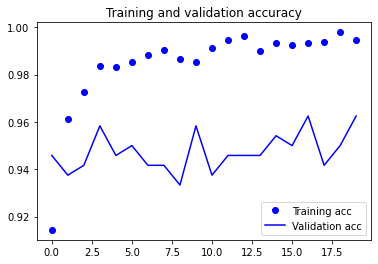

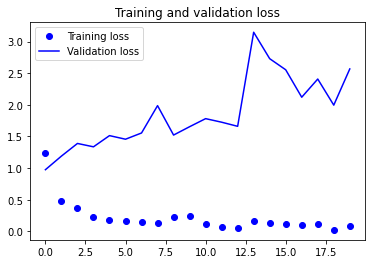

In [12]:
# 학습 과정의 accuracy와 loss 값을 plot
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
model.evaluate(test_data, steps=6)

6/6 [==============================] - 2s 244ms/step - loss: 0.7028 - accuracy: 0.9875


[0.702813446521759, 0.987500011920929]